In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Abstract
Activation is a core part of the "magic" of neural networks but it also contributes to their relative slowness and computational costs.

In [4]:
from typing import List, Dict
import json
import time

class Encoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)


class ResultSet:
    """Result set of one experiment
    
    Args:
        title: str.  Name of the result set.
        filename: str. Name of the file to store the results in. Should omit the 
            extension.  If no filename is given, one will be generated from the
            title

    
    """
    def __init__(self, title: str, filename: str = None):
        self.title = title
        if (filename):
            self.filename = filename if filename.endswith(".json") else (filename + ".json")
        else:
            self.filename = title.lower().replace(" ","_") + ".json"
        self.x = []
        self.y = []
        self.labels = []
        self.last_saved_on = None
        
    def save(self):
        self.last_saved_on = time.time()
        with open(f"{self.filename}.json", "w") as f:
            json.dump(self.__dict__, f, cls=Encoder)
            
    @staticmethod
    def load(name: str):
        with open(f"{name}.json", "r") as f:
            data = json.load(f)
            result = ResultSet(data['title'], data['filename'])
            result.x = data['x']
            result.y = data['y']
            result.labels = data['labels']
            result.last_saved_on = data['last_saved_on']
            return result
        
    def add(self, label: str, x: List[float], y: List[float]):
        self.x.append(x)
        self.y.append(y)
        self.labels.append(label)
        
    def get(self, label: str) -> Dict[List[float], List[float]]:
        return {'x': self.x[self.labels.index(label)], 'y': self.y[self.labels.index(label)]}

# Precomputed Activation Function

>
> __***reword this in terms of asymptotic functions for the upper and lower regions, $\alpha_\text{low}(x)$ and $\alpha_\text{high}(x)$.***__
>

Activation functions have a roughly ReLU-like or sigmoid-like shape:  they are continuous, continuously-differentiable (except, at inflection points), lower-bounded, sometime upper-bounded.  Some of these functions can be quite costly/long to compute, and these computations occur extremely often during training or prediction.  Indeed, newer activation functions like GELU or swish have grown in complexity over earlier one (unit step, ReLU).
To reduce computation costs and allow for maximum flexibility, we propose computing these activation at model initialization and performing mostly lookups during computations.  In other words, given an activation function $a(x)$, a new function $\tilde a(x) \approx a(x)$ is proposed as follows:
$$
\tilde a(x) = 
\begin{cases}
\alpha_\text{low}(x) & \text{if } x \lt x_\text{low}\\
A_{i(x)} & \text{if } x_\text{low} \le x \lt x_\text{high}\\
\alpha_\text{high}(x) & \text{if } x_\text{high} \le x
\end{cases}
$$
where $A$ is an $n$-tuple of precomputed values of $a(x)$ at the midpoint of each of $n$ regular intervals between $x_\text{low}$ and $x_\text{high}$, and $i(x)$ is the index of the interval in $A$ that contains $x$; it is simply given by 
$$
\forall x \in [x_\text{low}, x_\text{high}), i(x) = \left\lfloor \frac{n ( x - x_\text{low} )}{x_\text{high} - x_\text{low}} \right\rfloor
$$
Also, the left and right 'arms' of the function are given by the asymptotic tails $\alpha_\text{low}(x) \text{ s.t. } \lim_{x\to - \infty}\left(\alpha_\text{low}(x) - a(x)\right) = 0$

In [5]:
import numpy as np
import tensorflow as tf
from keras.src import activations, backend
from keras.src.api_export import keras_export
from keras.src.layers import Layer
from typing import Callable, List

@keras_export('keras.layers.PAF')
class PAF(Layer):
    """Pre-computed Activation Function Layer.
    
    Args:
        func: Callable, the activation function to be used to initialize the lookup table.
        x_low: float, the lower bound of the lookup table.
        x_high: float, the upper bound of the lookup table.
        func_low: Callable, the activation function to be used for x <= x_low.
        func_high: Callable, the activation function to be used for x >= x_high.
        n: int, the number of points in the lookup table.
            Default: 64

    Formula:
    ``` python
    f(x) = func_low(x) if x <= x_low
    f(x) = func_high(x) if x >= x_high
    f(x) is looked up in the computed lookup table if x_low < x < x_high
    ```
    """
    
    def __init__(self, func: Callable, x_low: float, x_high: float, func_low: Callable, func_high: Callable, n: int = 64, **kwargs):
        super().__init__(**kwargs)
        self.table = [func(x_low + (i + 0.5) * (x_high - x_low) / n) for i in range(n)]
        self.x_low = x_low
        self.x_high = x_high
        self.func_low = func_low
        self.func_high = func_high
        self.n = n
        self.mult = n / (x_high - x_low)
        self.add = (x_low * n) / (x_low - x_high)

    def call(self, inputs: List[float]):
        return tf.map_fn(self.lookup, backend.convert_to_tensor(inputs))
    
    def lookup(self, x):
        if x <= self.x_low:
            return self.func_low(x)
        elif x >= self.x_high:
            return self.func_high(x)
        else:
            idx = np.floor(x * self.mult + self.add).astype(int)
            return self.table[idx]
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'x_low': self.x_low,
            'x_high': self.x_high,
            'func_low': self.func_low,
            'func_high': self.func_high,
            'n': self.n,
            'table': self.table
        })
        return config
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_xy(self):
        return np.linspace(self.x_low, self.x_high, self.n).tolist(), self.table

### Finding optimal $x_\text{low}$ and $x_\text{high}$

In [65]:
#for x in [5., 4., 3., 2., 1., 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
#    print(f"{x}: {approx_error(-x, x, lambda z: tf.nn.silu(z).numpy(), lambda z: 0, lambda z: z)}")

In [6]:
import matplotlib.pyplot as plt
from IPython.display import FileLink, FileLinks
from typing import Tuple
import math, os

def compare(func: Callable, name: str, func_low: Callable, func_high: Callable, paf_params: List[Tuple[int, float, float]]) -> ResultSet:
    filename = f"val_{name}_PAFs.json"
    if (os.path.isfile(filename)):
        retVal = ResultSet.load(filename)
        print(f'Loaded {filename} from {time.strftime("%Y-%m-%dT%H:%M:%S %z", time.localtime(retVal.last_saved_on))}')
    else:
        print(f"Generating data for {filename}")
        retVal = ResultSet(f"Comparison of values between {name} and corresponding PAFs",
                           filename)
        print(f"...Generating {name}")
        x_func = np.linspace(-10, 10, 1000).tolist()
        y_func = func(x_func).tolist()
        retVal.add(name, x_func, y_func)
    
        for params in paf_params:
            n = params[0]
            x_low = params[1]
            x_high = params[2]
            print(f"...Generating {n} (PAF & diff)")            
            paf = PAF(func, x_low, x_high, func_low, func_high, n)
            x_paf_only, y_paf_only = paf.get_xy()
            x1 = [n/100. for n in range(-1000, int(math.floor(min(x_paf_only)*100)))]
            y1 = [func_low(a) for a in x1]
            x2 = [n/100. for n in range(int(math.ceil(max(x_paf_only)*100)), 1000)]
            y2 = [func_high(a) for a in x2]

            x_paf = x1 + x_paf_only + x2
            y_paf = y1 + y_paf_only + y2
            y_func = func(x_paf).tolist()

            retVal.add(f"{n}",x_paf , y_paf)
            retVal.add(f"diff {n}", x_paf, [abs(a - paf) for a, paf in zip(y_func, y_paf)])
        
        print(f"...Saving")
        retVal.save()
        display(FileLinks("."))
        
    plt.figure(figsize=(11, 4), layout='constrained')
    plt.suptitle(retVal.title)
    
    ax1 = plt.subplot(1, 3, 1)
    minx = 10
    maxx = -10
    for lbl in retVal.labels:
        if (not lbl.startswith("diff ")):
            f = retVal.get(lbl)
            plt.plot(f['x'], f['y'], label=lbl, linewidth=0.5)
            minx = min(minx, min(f['x']))
            maxx = max(maxx, max(f['x']))
    plt.xlim(minx, maxx)
    plt.ylim(-1,7)
    plt.title(f"{name} and corresponding PAFs")
    ax1.legend()
    
    ax2 = plt.subplot(1, 3, 2)
    for lbl in retVal.labels:
        if (not lbl.startswith("diff ")):
            f = retVal.get(lbl)
            plt.plot(f['x'], f['y'], label=lbl, linewidth=0.5)
    plt.xlim(-0.75, 0.25)
    plt.ylim(-.3, .7)
    plt.title(f"{name} and corresponding PAFs around 0")
    ax2.legend()

    ax3 = plt.subplot(1, 3, 3)
    minx = 10
    maxx = -10
    for lbl in retVal.labels:
        if (lbl.startswith("diff ")):
            f = retVal.get(lbl)
            plt.plot(f['x'], f['y'], label=lbl, linewidth=0.5)
            minx = min(minx, min(f['x']))
            maxx = max(maxx, max(f['x']))
    plt.xlim(minx, maxx)
    plt.ylim(0, 0.03)
    plt.title(f"Absolute errors wrt {retVal.labels[0]}")
    ax3.legend()
   
    plt.show()
    
    return retVal

In [ ]:
#print(yaml.__version__)
#display(FileLinks("."))
#os.remove("/kaggle/working/val_GELU_PAFs.yaml")
#os.remove("/kaggle/working/val_Swish_PAFs.yaml")


Generating data for val_GELU_PAFs.json
...Generating GELU
...Generating 64 (PAF & diff)
...Generating 256 (PAF & diff)
...Saving


./
  PAF error estimation validation.xlsx
  PAF-optimal_bounds.ipynb
  pre-computed-activation-function.ipynb
  report.log
  val_GELU_PAFs.json.json
  val_swish_pafs.csv
  val_Swish_PAFs.json.json

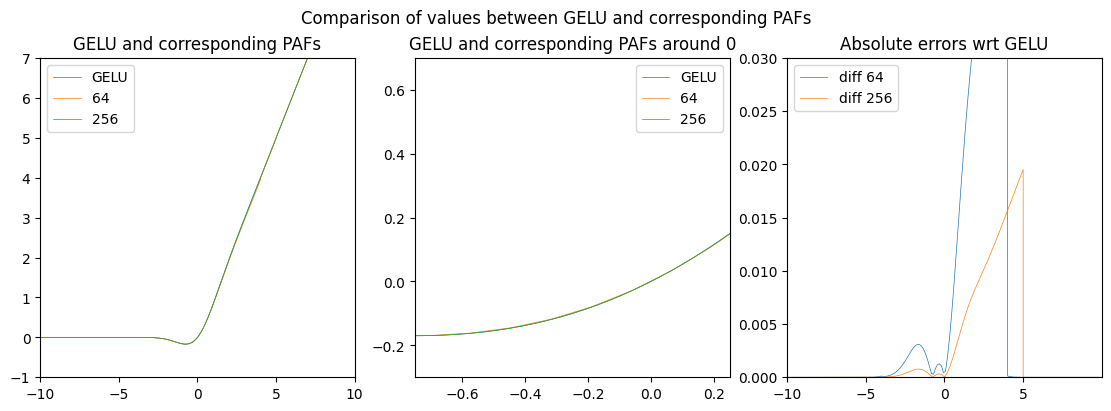

In [17]:
_ = compare(
    lambda x: tf.nn.gelu(x, approximate=False).numpy(), "GELU",
    lambda x: 0.,
    lambda x: x,
    [(64, -4., 4.),
     (256, -5., 5.)
     ]
)

Generating data for val_Swish_PAFs.json
...Generating Swish
...Generating 256 (PAF & diff)
...Generating 1024 (PAF & diff)
...Generating 4096 (PAF & diff)
...Generating 8192 (PAF & diff)
...Saving


./
  PAF error estimation validation.xlsx
  PAF-optimal_bounds.ipynb
  pre-computed-activation-function.ipynb
  report.log
  val_GELU_PAFs.json.json
  val_swish_pafs.csv
  val_Swish_PAFs.json.json
.\.vscode/
  settings.json

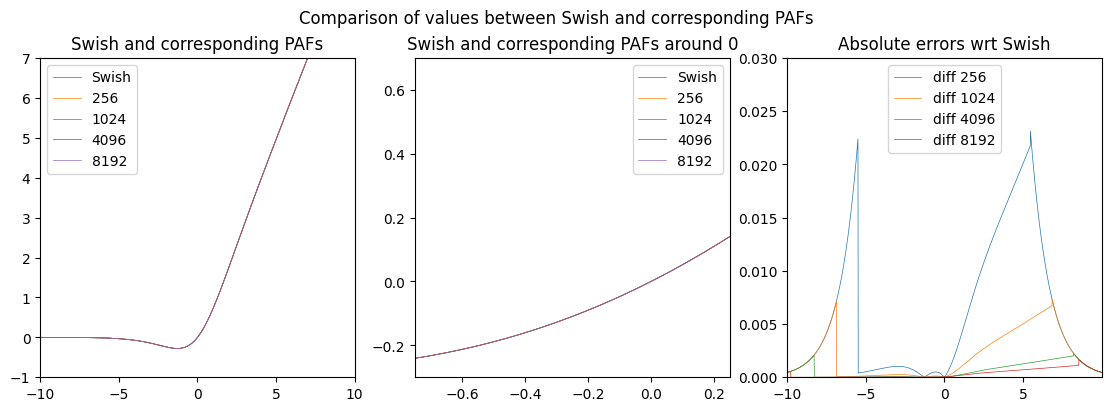

In [29]:
_ = compare(
    lambda x: tf.nn.silu(x).numpy(), "Swish",
    lambda x: 0.,
    lambda x: x,
    [(256, -5.48322987, 5.45971842),
     (1024, -6.85589938, 6.83348667),
     (4096, -8.27510547,  8.20489237),
     (8192, -9.7693, 8.5318)])


In [ ]:
import pandas as pd

r = ResultSet.load('val_swish_PAFs')

df = pd.DataFrame()
df['x'] = r.x
for lbl in r.labels:
    df[lbl] = r.get_y(lbl)

df.to_csv('val_swish_pafs.csv', index=False)
display(FileLinks("."))


The "horns" on the left and right of figure.

{1} test